In [33]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta

# Define date ranges
in_sample_start = '2015-01-01'
in_sample_end = '2020-12-31'
out_sample_start = '2021-01-01'
out_sample_end = '2023-10-31'

# Define the list of FOREX symbols for each strategy
symbols_tam = ['EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'AUDUSD=X']  # Major currency pairs for Turnaround Monday Strategy
symbols_nih = ['EURGBP=X', 'EURJPY=X', 'GBPJPY=X', 'USDCHF=X', 'USDCAD=X']  # Cross pairs for New Intraday High Strategy

# Initialize lists to store results
list_trades_tam = []
list_trades_nih = []

# Function to fetch daily data with error handling
def fetch_daily_data(symbol, start_date, end_date):
    print(f"Fetching daily data for {symbol} from {start_date} to {end_date}...")
    try:
        data = yf.download(symbol, start=start_date, end=end_date, interval='1d', progress=False)
        if data.empty:
            print(f"No data returned for {symbol} from {start_date} to {end_date}.")
        return data
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return pd.DataFrame()

# Function to process Turnaround Monday Strategy
def process_turnaround_monday(symbol):
    # Fetch daily data for both in-sample and out-of-sample periods
    data_in_sample = fetch_daily_data(symbol, in_sample_start, in_sample_end)
    data_out_sample = fetch_daily_data(symbol, out_sample_start, out_sample_end)

    # Combine the data
    data_daily = pd.concat([data_in_sample, data_out_sample])

    if data_daily.empty:
        return pd.DataFrame()  # Return empty DataFrame if data is empty

    data_daily['Return'] = data_daily['Close'].pct_change()
    data_daily['Weekday'] = data_daily.index.weekday  # Monday=0, Friday=4

    # Identify negative Fridays
    data_daily['Friday Negative'] = (data_daily['Return'] < 0) & (data_daily['Weekday'] == 4)
    data_daily['Buy Signal'] = data_daily['Friday Negative'].shift(1) & (data_daily['Weekday'] == 0)

    # Simulate Trades
    trades = simulate_trades_tam(data_daily, symbol)

    return trades

# Function to simulate trades for Turnaround Monday Strategy
def simulate_trades_tam(data, symbol):
    trades = []
    buy_signals = data[data['Buy Signal']]
    for idx, row in buy_signals.iterrows():
        entry_date = idx
        exit_date = idx + pd.Timedelta(days=3)  # Exit after 3 days

        # Adjust for market days
        if exit_date not in data.index:
            # Find the closest available date
            dates = data.index
            if len(dates) == 0:
                continue
            exit_date = min(dates, key=lambda d: abs(d - exit_date))

        entry_price = data.loc[entry_date]['Close']
        exit_price = data.loc[exit_date]['Close']

        sample_period = 'In-Sample' if in_sample_start <= str(entry_date.date()) <= in_sample_end else 'Out-of-Sample'

        return_pct = (exit_price - entry_price) / entry_price * 100
        trades.append({
            'Symbol': symbol,
            'Entry Date': entry_date,
            'Exit Date': exit_date,
            'Entry Price': entry_price,
            'Exit Price': exit_price,
            'Return (%)': return_pct,
            'Sample': sample_period
        })
    return pd.DataFrame(trades)

# Process Turnaround Monday Strategy for all symbols
for symbol in symbols_tam:
    trades = process_turnaround_monday(symbol)
    if not trades.empty:
        list_trades_tam.append(trades)

# Concatenate all trades into a single DataFrame
df_trades_tam = pd.concat(list_trades_tam, ignore_index=True) if list_trades_tam else pd.DataFrame()

# Function to process New Intraday High Strategy
def process_new_intraday_high(symbol):
    # Fetch daily data for both in-sample and out-of-sample periods
    data_in_sample = fetch_daily_data(symbol, in_sample_start, in_sample_end)
    data_out_sample = fetch_daily_data(symbol, out_sample_start, out_sample_end)

    # Combine the data
    data_daily = pd.concat([data_in_sample, data_out_sample])

    if data_daily.empty:
        return pd.DataFrame()

    data_daily['Previous High'] = data_daily['High'].shift(1)
    data_daily['Buy Signal'] = data_daily['Open'] > data_daily['Previous High']

    # Simulate Trades
    trades = simulate_trades_nih(data_daily, symbol, in_sample_start, in_sample_end)

    return trades

# Function to simulate trades for New Intraday High Strategy
def simulate_trades_nih(data, symbol, in_sample_start, in_sample_end):
    trades = []
    buy_signals = data[data['Buy Signal']]
    for idx, row in buy_signals.iterrows():
        entry_date = idx
        entry_price = row['Open']
        exit_price = row['Close']  # Exit at the close of the same day

        sample_period = 'In-Sample' if in_sample_start <= str(entry_date.date()) <= in_sample_end else 'Out-of-Sample'

        return_pct = (exit_price - entry_price) / entry_price * 100
        trades.append({
            'Symbol': symbol,
            'Entry Date': entry_date,
            'Exit Date': entry_date,
            'Entry Price': entry_price,
            'Exit Price': exit_price,
            'Return (%)': return_pct,
            'Sample': sample_period
        })
    return pd.DataFrame(trades)

# Process New Intraday High Strategy for all symbols
for symbol in symbols_nih:
    trades = process_new_intraday_high(symbol)
    if not trades.empty:
        list_trades_nih.append(trades)

# Concatenate all trades into a single DataFrame
df_trades_nih = pd.concat(list_trades_nih, ignore_index=True) if list_trades_nih else pd.DataFrame()

# Function to calculate performance metrics
def calculate_performance_metrics(data, initial_portfolio_value):
    if data.empty:
        return {
            "Final Portfolio Value": initial_portfolio_value,
            "Total Trades": 0,
            "Average Return/Trade": 0,
            "Percentage Profitable": 0,
            "Win Rate": 0
        }

    data = data.sort_values('Entry Date').reset_index(drop=True)
    data['Portfolio Value'] = initial_portfolio_value * (1 + data['Return (%)'] / 100).cumprod()
    final_portfolio_value = data['Portfolio Value'].iloc[-1]
    total_trades = len(data)
    average_return = data['Return (%)'].mean()
    profitable_trades = len(data[data['Return (%)'] > 0])
    win_rate = (profitable_trades / total_trades) * 100 if total_trades > 0 else 0

    return {
        "Final Portfolio Value": final_portfolio_value,
        "Total Trades": total_trades,
        "Average Return/Trade": average_return,
        "Percentage Profitable": (profitable_trades / total_trades) * 100,
        "Win Rate": win_rate
    }

# Function to generate performance summary
def generate_performance_summary(df_trades, strategy_name):
    if df_trades.empty:
        print(f"No trades were executed for {strategy_name}.")
        return pd.DataFrame()

    performance_summaries = []

    # Split data by Sample and Symbol
    grouped = df_trades.groupby(['Sample', 'Symbol'])
    for (sample, symbol), group in grouped:
        metrics = calculate_performance_metrics(group, initial_portfolio_value=10000)
        performance_summaries.append({
            'Sample': sample,
            'Symbol': symbol,
            **metrics
        })

    performance_df = pd.DataFrame(performance_summaries)
    print(f"\nPerformance Summary - {strategy_name}:")
    print(performance_df)
    return performance_df

# Generate performance summaries for both strategies
print("========== Turnaround Monday Strategy ==========")
summary_tam = generate_performance_summary(df_trades_tam, "Turnaround Monday Strategy")

print("\n========== New Intraday High Strategy ==========")
summary_nih = generate_performance_summary(df_trades_nih, "New Intraday High Strategy")


Fetching daily data for EURUSD=X from 2015-01-01 to 2020-12-31...
Fetching daily data for EURUSD=X from 2021-01-01 to 2023-10-31...
Fetching daily data for GBPUSD=X from 2015-01-01 to 2020-12-31...
Fetching daily data for GBPUSD=X from 2021-01-01 to 2023-10-31...
Fetching daily data for USDJPY=X from 2015-01-01 to 2020-12-31...
Fetching daily data for USDJPY=X from 2021-01-01 to 2023-10-31...
Fetching daily data for AUDUSD=X from 2015-01-01 to 2020-12-31...
Fetching daily data for AUDUSD=X from 2021-01-01 to 2023-10-31...
Fetching daily data for EURGBP=X from 2015-01-01 to 2020-12-31...
Fetching daily data for EURGBP=X from 2021-01-01 to 2023-10-31...
Fetching daily data for EURJPY=X from 2015-01-01 to 2020-12-31...
Fetching daily data for EURJPY=X from 2021-01-01 to 2023-10-31...
Fetching daily data for GBPJPY=X from 2015-01-01 to 2020-12-31...
Fetching daily data for GBPJPY=X from 2021-01-01 to 2023-10-31...
Fetching daily data for USDCHF=X from 2015-01-01 to 2020-12-31...
Fetching d

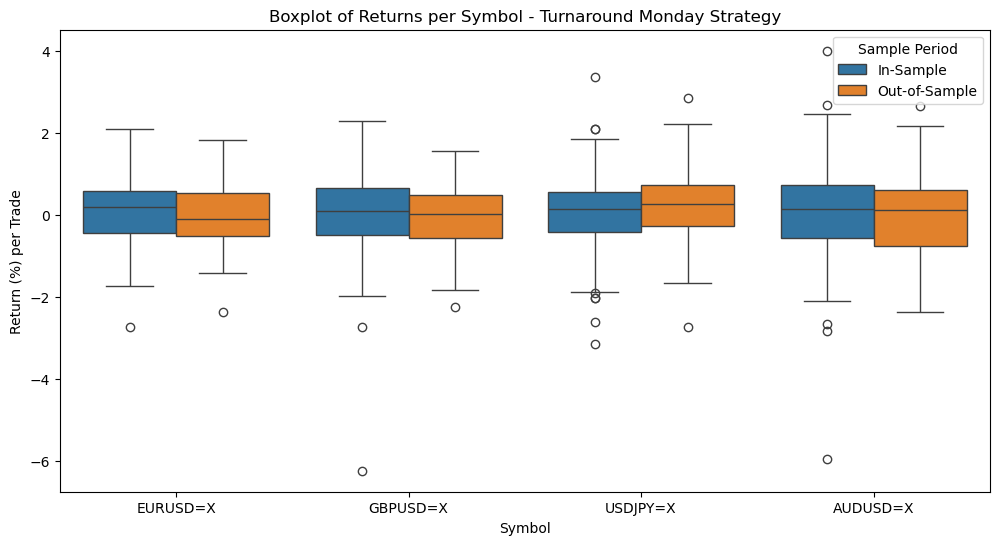

<Figure size 640x480 with 0 Axes>

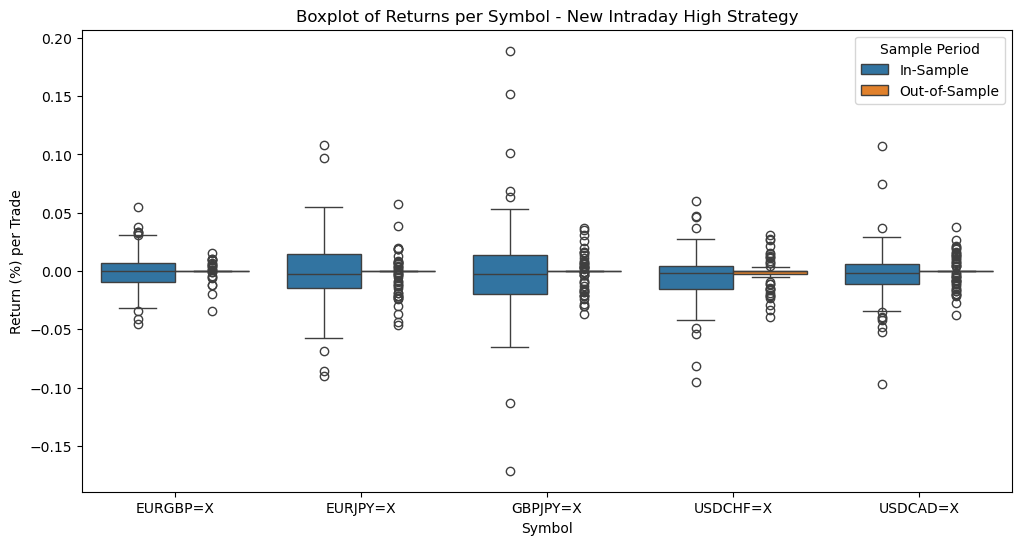

<Figure size 640x480 with 0 Axes>

In [29]:
def plot_boxplot_returns(df_trades, strategy_name):
    if df_trades.empty:
        print(f"No trades to plot for {strategy_name}.")
        return

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Symbol', y='Return (%)', hue='Sample', data=df_trades)
    plt.title(f'Boxplot of Returns per Symbol - {strategy_name}')
    plt.xlabel('Symbol')
    plt.ylabel('Return (%) per Trade')
    plt.legend(title='Sample Period')
    plt.show()

# Plot boxplots for both strategies
plot_boxplot_returns(df_trades_tam, "Turnaround Monday Strategy")
plt.savefig('boxplot_turnaround_monday.png', dpi=300, bbox_inches='tight')
plot_boxplot_returns(df_trades_nih, "New Intraday High Strategy")
plt.savefig('boxplot_new_intraday_high.png', dpi=300, bbox_inches='tight')
